<h1 style="text-align: center;">Stroke Prediction</h1>

<h3 style="text-align: center;">5. Explainability with SHAP</h3>

<p style="text-align: center;">Hugo Gálvez</p>

In the healthcare field, it is crucial that the results provided by models are understandable to doctors and other professionals in the area. Decision Trees are particularly useful in this regard, as they offer visual diagrams that clearly identify the factors leading to a prediction. Although Random Forest and XGBoost are more complex, techniques like feature importance and `SHAP` (SHapley Additive Explanations) allow for extracting useful interpretations from these models (Lundberg & Lee, 2017).

In [1]:
# General libraries
import pandas as pd
import numpy as np
import joblib

# Scikit-learn: preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# TensorFlow and Keras
from tensorflow.keras.models import load_model

# SHAP
import shap
shap.initjs()

# Visualization
from IPython.display import display

## Global Data Configuration

The cleaned data is loaded and split into training and test sets using stratified sampling to preserve the original class proportions. The preprocessing pipeline, which includes standardizing numerical variables and encoding categorical ones, is also loaded. Finally, the data is preprocessed to ensure it is ready for analysis with SHAP and the model.

In [2]:
# Configuration
seed = 12345
np.random.seed(seed)

# Load the cleaned dataset
data = pd.read_csv('cleaned_healthcare_dataset.csv')

# Separate features and target variable
X = data.drop(columns=['stroke'])
y = data['stroke']

# Split the data into training (67%) and test (33%) sets with seed = 12345
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=seed, stratify=y
)

# Categorical and numerical variables
categorical_features = [
    'gender', 'hypertension', 'heart_disease', 'ever_married',
    'work_type', 'Residence_type', 'smoking_status'
]
numerical_features = ['age', 'avg_glucose_level', 'bmi']

preprocessor = joblib.load('preprocessor.pkl')

# Fit and transform training data
X_train_transformed = preprocessor.transform(X_train)

# Transform test data
X_test_transformed = preprocessor.transform(X_test)

## Load the Model

The previously optimized model is loaded from a `.keras` file. Verifying its structure with `summary()` ensures it is ready to be evaluated and interpreted with SHAP, providing a reliable starting point for the interpretability analysis.

In [3]:
# Load the saved complete model
model = load_model("best_ann.keras")
print("Complete model loaded successfully.")

# Verify the model structure
model.summary()

Complete model loaded successfully.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 50)             │           950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,415 (17.25 KB)

 Trainable params: 1,471 (5.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,944 (11.50 KB)

## Calculate SHAP Values

A subset of the training set is defined to accelerate the calculation of SHAP values, selecting representative background samples. Next, a SHAP explainer is created using the loaded model and the reduced dataset. This allows for generating SHAP values for a subset of the test set, facilitating the analysis of how each feature impacts the model's predictions.

In [4]:
feature_names = preprocessor.get_feature_names_out()

# Select stratified background data
background_data = X_train_transformed
joblib.dump(background_data, "background_data.pkl")

# Create the SHAP explainer using the general interface
explainer = shap.Explainer(model, background_data, framework='tensorflow')

# Generate SHAP values for a subset of the test data
sample_size = 1000  # Number of examples to analyze
X_test_sample = X_test_transformed[np.random.choice(
    X_test_transformed.shape[0], sample_size, replace=False)]
shap_values = explainer(X_test_sample)
shap_values.feature_names = feature_names.tolist()

PermutationExplainer explainer: 1001it [00:50, 17.21it/s]                         


### Reverse Transformations of Variables

The transformed values of numerical and categorical features are reversed to facilitate graphical interpretation. This step ensures that SHAP visualizations are intuitive and reflect the original features, enhancing the understanding of how the model uses each input to make predictions.

In [5]:
def revert_transformations(shap_values, preprocessor, numerical_features,
                           categorical_features):
    """
    Reverts transformations applied to the data for improved graphical visualization with SHAP.
    
    Args:
        shap_values (shap.Explanation): SHAP values computed for the dataset.
        preprocessor (ColumnTransformer): Preprocessor object used to transform the data.
        numerical_features (list): List of numerical features.
        categorical_features (list): List of categorical features.
    
    Returns:
        tuple: (data_reverted, feature_names_reverted)
            - data_reverted (np.ndarray): Reverted data (without transformation).
            - feature_names_reverted (list): Reverted feature names.
    """
    # Revert numerical features
    scaler = preprocessor.named_transformers_['num']
    data_reverted = shap_values.data.copy()
    data_reverted[:, :len(numerical_features)] = (
        data_reverted[:, :len(numerical_features)] * scaler.scale_ + scaler.mean_
    )
    
    # Revert categorical features
    encoder = preprocessor.named_transformers_['cat']
    onehot_feature_names = encoder.get_feature_names_out(categorical_features)
    
    # Update feature names with the originals
    feature_names_reverted = list(numerical_features) + list(onehot_feature_names)
    
    return data_reverted, feature_names_reverted

The SHAP values are updated with the reverted data and the original feature names, ensuring that the visualizations and analyses are clear and aligned with the model's original inputs.

In [6]:
# Revert transformations and update the values and names directly in shap_values
shap_values.data, shap_values.feature_names = revert_transformations(
    shap_values=shap_values,
    preprocessor=preprocessor,
    numerical_features=numerical_features,
    categorical_features=categorical_features
)

## SHAP Values Analysis for the Test Dataset

We verify the structure and content of the generated SHAP values. This ensures that the data is consistent and suitable for visual analysis. An initial inspection is performed using a beeswarm plot, which shows the relative influence of features on the model's predictions, highlighting the most important ones.

In [7]:
# Verify the structure of SHAP values
print(f"Type of shap_values: {type(shap_values)}")
print(f"Shape of shap_values.values: {shap_values.values.shape}")

# Inspect some SHAP values
print("Example of SHAP values for the first test instance:")
print(shap_values.values[0])

Type of shap_values: <class 'shap._explanation.Explanation'>
Shape of shap_values.values: (1000, 18)
Example of SHAP values for the first test instance:
[-0.41677416  0.00256233 -0.06413966  0.          0.00110389 -0.00164478
  0.00298595  0.0072734   0.          0.0124044   0.01461393  0.01293351
  0.04968442  0.          0.00762891  0.00546156 -0.00160142 -0.01338903]


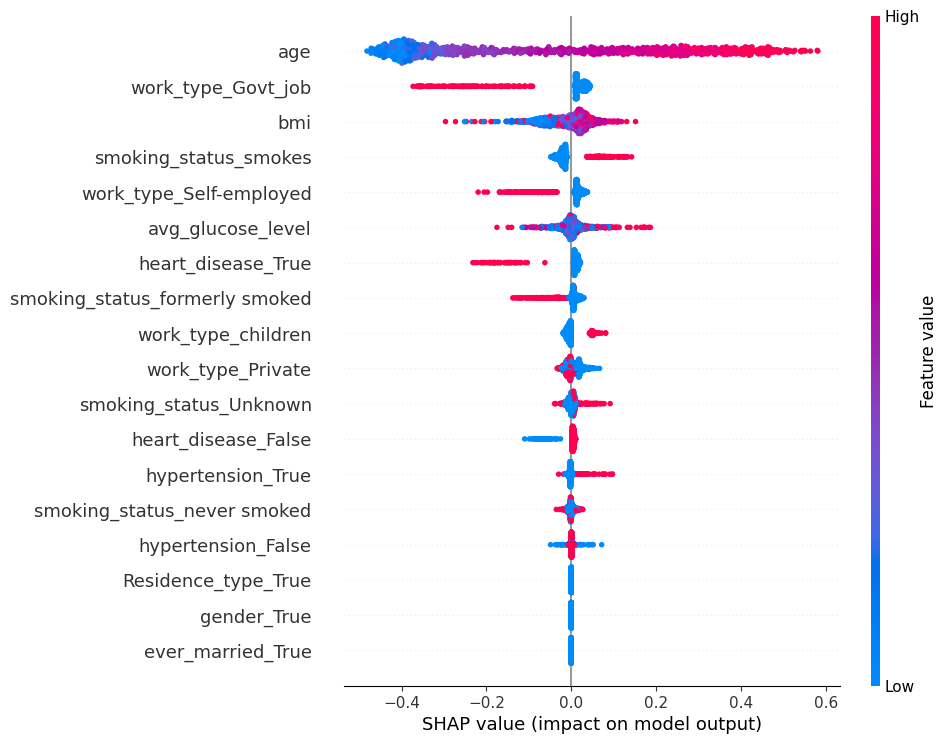

In [8]:
shap.plots.beeswarm(shap_values, max_display=20)

A force plot is used to display a set of predictions, flattening the base values. This provides an aggregated view of how features influence predictions across different instances, highlighting global trends.

In [9]:
# Flatten base_values to adjust to shap.plots.force
base_values_flattened = shap_values.base_values.flatten()

# Generate the force plot
sample_size = 50  # Number of samples to display
shap.plots.force(base_values_flattened[:sample_size],
                 shap_values.values[:sample_size],
                 feature_names=shap_values.feature_names)

A bar plot is generated showing the most important features, highlighting the average contribution of each to the model's predictions. This plot is useful for concisely communicating which variables are key in the model, reinforcing the connection to the clinical context.

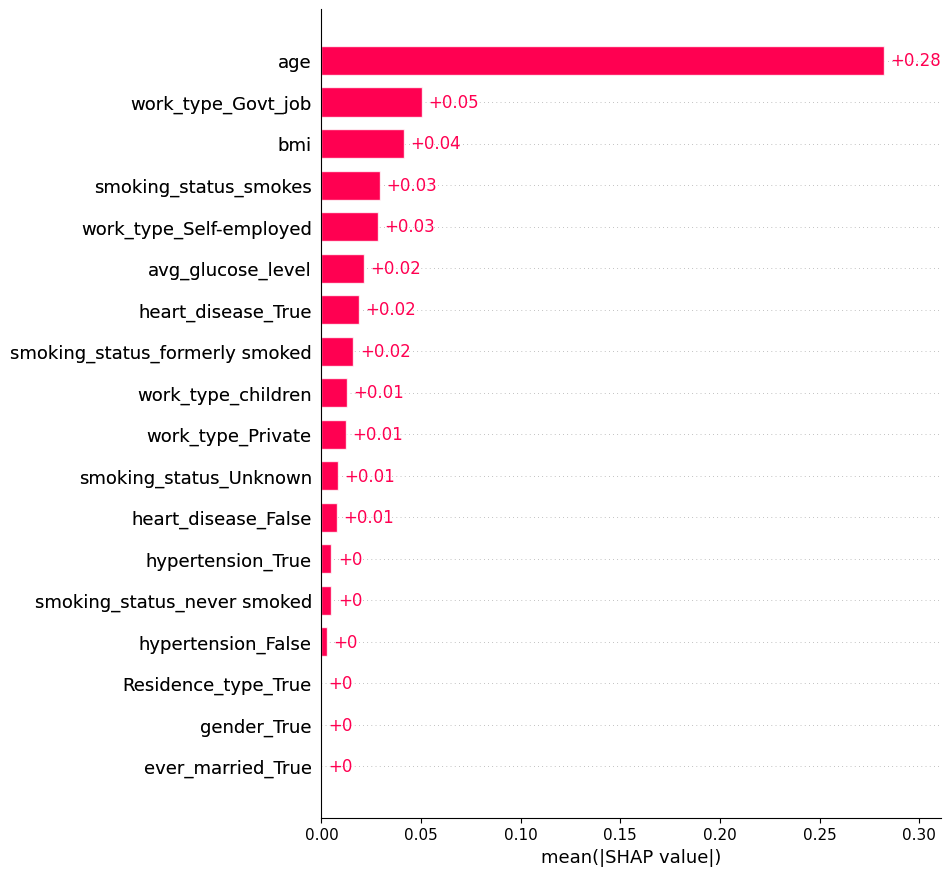

In [10]:
shap.plots.bar(shap_values, max_display=20)

The average absolute importance of SHAP values for all features is calculated and sorted. This quantitatively identifies which variables are most relevant to the model, providing crucial information to justify the model's use in the clinical domain.

In [11]:
# Clean feature names
clean_feature_names = [name.split('__')[-1] for name in feature_names]
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

# Create the DataFrame with cleaned names and no index
feature_importance_df = pd.DataFrame({
    "Feature": clean_feature_names,
    "Mean Absolute SHAP Value": mean_abs_shap_values
}).sort_values(by="Mean Absolute SHAP Value", ascending=False)

# Display the table without indices
display(feature_importance_df.style.hide(axis='index'))

Feature,Mean Absolute SHAP Value
age,0.282241
work_type_Govt_job,0.050288
bmi,0.041317
smoking_status_smokes,0.029221
work_type_Self-employed,0.028364
avg_glucose_level,0.021133
heart_disease_True,0.018606
smoking_status_formerly smoked,0.016007
work_type_children,0.012721
work_type_Private,0.012284


## SHAP Values for New Individual Predictions

Let’s revisit our previous example, where we made a prediction for a new individual. We will start by retrieving our functions.

In [12]:
def preprocess_input(person_data, preprocessor):
    """
    Converts a person's input data into the format expected by the model.

    Args:
        person_data (dict): Dictionary with the person's information, with keys 
        such as 'age', 'gender', etc.
        preprocessor (ColumnTransformer): Pre-fitted preprocessor object.

    Returns:
        np.array: Transformed data ready for the model.
    """
    # Validate keys in the input data
    required_keys = numerical_features + categorical_features
    missing_keys = [key for key in required_keys if key not in person_data]
    if missing_keys:
        raise ValueError(f"Missing required keys: {missing_keys}")
    
    # Convert the data into a DataFrame for easier preprocessing
    df = pd.DataFrame([person_data])[numerical_features + categorical_features]

    # Transform the data
    transformed_data = preprocessor.transform(df)
    
    # Ensure it is a NumPy array
    return np.array(transformed_data)


def get_stroke_prediction(person_data, model, preprocessor):
    """
    Obtains the stroke probability for a person using the loaded model and 
    preprocessor.

    Args:
        person_data (dict): Person's data.
        model (keras.Model): Previously loaded neural network model.
        preprocessor (ColumnTransformer): Previously loaded preprocessor.

    Returns:
        float: Stroke probability.
    """
    # Preprocess data and predict
    transformed_data = preprocess_input(person_data, preprocessor)
    probability = model.predict(transformed_data)[0][0]
    return probability

We define the parameters for the new patient and calculate the probability of `stroke`.

In [13]:

# Define the new patient's parameters
new_person = {
    'gender': 'Female',
    'age': 72.5,
    'hypertension': True,
    'heart_disease': False,
    'ever_married': True,
    'work_type': 'Private',
    'Residence_type': 'Urban',
    'avg_glucose_level': 135.7,
    'bmi': 29.3,
    'smoking_status': 'formerly smoked'
}

# Calculate the stroke probability
probability = get_stroke_prediction(new_person, model, preprocessor)
print(f"Stroke probability for the new patient: {probability:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Stroke probability for the new patient: 89.09%


We get the SHAP values for this patient

In [14]:
# Preprocess the new person's data
np_transformed_data = preprocess_input(new_person, preprocessor)

# Calculate SHAP values for the new person
np_shap_values = explainer(np_transformed_data)

# Update the values and names in the SHAP object for the new person
np_shap_values.data, np_shap_values.feature_names = revert_transformations(
    shap_values=np_shap_values,
    preprocessor=preprocessor,
    numerical_features=numerical_features,
    categorical_features=categorical_features
)

In [15]:
np_shap_values

.values =
array([[ 4.06994503e-01,  1.54714337e-02,  1.75830172e-02,
         1.99009906e-02,  1.18018466e-05,  2.49713051e-02,
         4.43877087e-03,  1.32522549e-02,  0.00000000e+00,
         2.69258526e-02, -6.10106468e-03,  1.46535067e-02,
        -1.31819507e-03,  3.66002660e-03,  5.57391934e-03,
        -1.49404480e-02, -4.37926479e-03, -1.70814065e-02]])

.base_values =
array([[0.38127258]])

.data =
array([[ 72.5, 135.7,  29.3,   0. ,   0. ,   1. ,   1. ,   0. ,   1. ,
          0. ,   1. ,   0. ,   0. ,   0. ,   0. ,   1. ,   0. ,   0. ]])

We generate a `force plot` for the individual example, intuitively showing how each feature contributes positively or negatively to the model's prediction. This helps understand the reasoning behind a specific prediction.

In [16]:
shap.plots.force(np_shap_values.base_values[0],
                 np_shap_values.values[0],
                 feature_names=np_shap_values.feature_names)

The waterfall plot breaks down the prediction of an individual example into cumulative contributions by feature. This approach makes it easier to identify the most influential factors in each prediction, supporting the interpretability narrative.

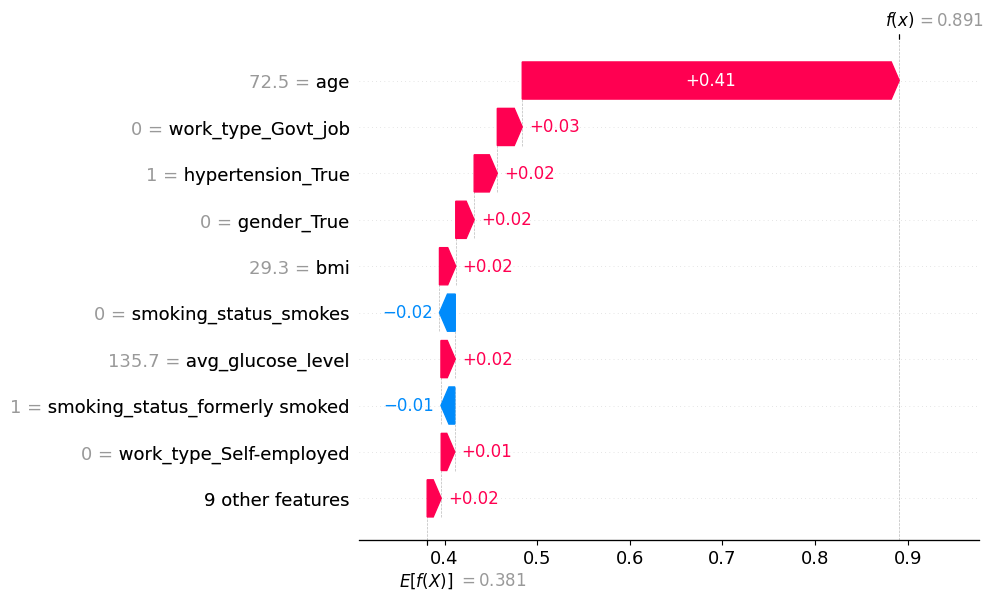

In [17]:
shap.plots.waterfall(np_shap_values[0])

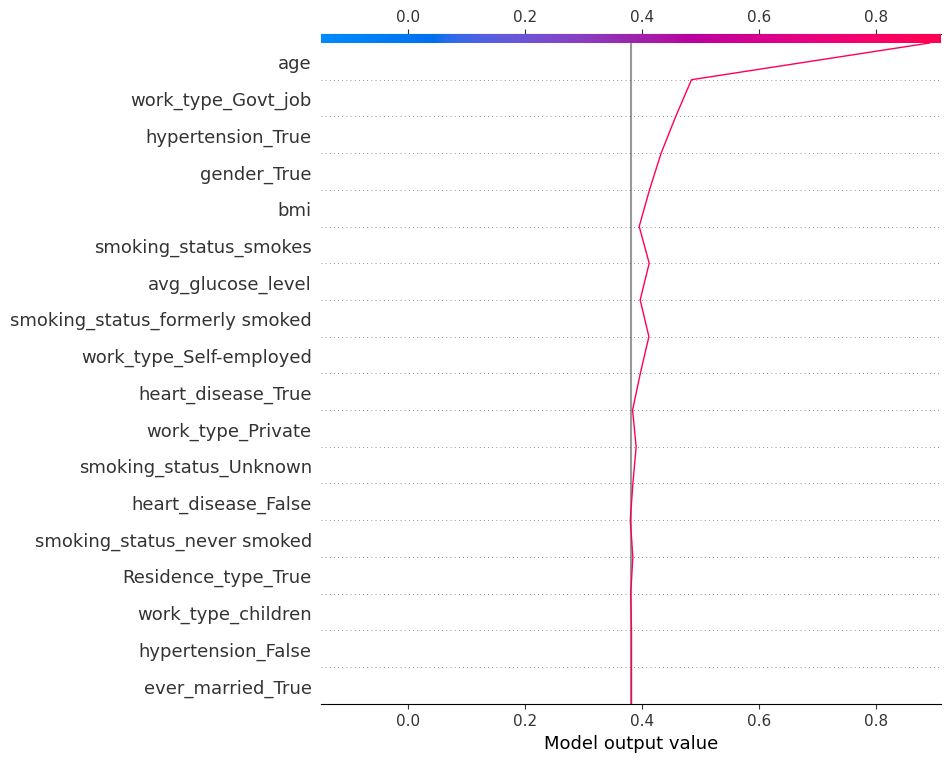

In [18]:
shap.decision_plot(
    np_shap_values.base_values[0],
    np_shap_values.values[0],
    np_shap_values.feature_names
)

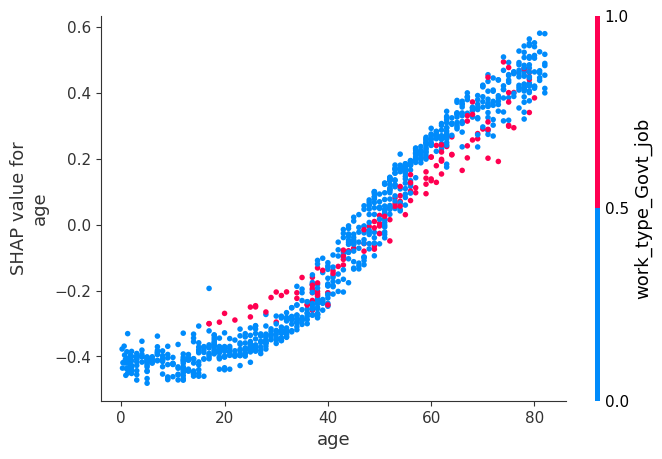

In [19]:
# Create a DataFrame with reverted values and feature names
data_df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)

# Call the dependence plot
shap.dependence_plot('age', shap_values.values, data_df)

# Referencias

- Angermueller, C., Pärnamaa, T., Parts, L., & Stegle, O. (2016). Deep learning for computational biology. *Molecular systems biology*, 12(7), 878.

- Bosch Rué, A., Casas Roma, J., & Lozano Bagén, T. (2019). *Deep Learning: Principios y Fundamentos*. Editorial UOC. Retrieved from [here](http://www.editorialuoc.com).

- Codecademy. (2024). *Normalization*. Retrieved from [here](https://www.codecademy.com/article/normalization).

- DataCamp. (2024). *Normalization in Machine Learning*. Retrieved from [here](https://www.datacamp.com/tutorial/normalization-in-machine-learning).

- Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. *Computing in Science & Engineering*, 9(3), 90-95. doi: 10.1109/MCSE.2007.55.

- IBM. (2024). *Jupyter Notebook Markdown Cheatsheet*. Retrieved from [here](https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet).

- Keras. (2024). *Keras Examples*. Retrieved from [here](https://keras.io/examples/).

- LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. *Nature*, 521(7553), 436-444. DOI: 10.1038/nature14539.

- Neural networks with Python by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py35-redes-neuronales-python).

- Scikit-learn: Machine Learning in Python. (2011). *Journal of Machine Learning Research*, 12, 2825-2830.

- TensorFlow. (2024). *tf.keras.utils.plot_model*. Retrieved from [here](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

- Waskom, M. L. (2021). seaborn: statistical data visualization. *Journal of Open Source Software*, 6(60), 3021. [DOI](https://doi.org/10.21105/joss.03021).

- Machine Learning with Python and Scikit-learn by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn).

- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... Duchesnay, E. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825-2830.

- Calibrate machine learning models by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py11-calibrar-modelos-machine-learning).

- Machine Learning with Python and Scikitlearn by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn).

- Neural networks with Python by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py35-redes-neuronales-python).

- Multiple linear regression with Python by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py10b-regresion-lineal-multiple-python).

- Using pandas category to encode categorical variables in machine learning models by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py55-pandas-category-modelos-machine-learning). 

- OpenAI Community. (2025). *Issue with accessing 'choices' attribute from OpenAI API response*. Retrieved from [here](https://community.openai.com/t/issue-with-accessing-choices-attribute-from-openai-api-response/362725).

- Ebbelaar, D. (2025). *Streamlit Chatbot Interface*. GitHub Repository. Retrieved from [here](https://github.com/daveebbelaar/streamlit-chatbot-interface/tree/main).

- OpenAI Community. (2025). *Content is a required property error (400)*. Retrieved from [here](https://community.openai.com/t/content-is-required-property-error-400/486260/2).

- Stack Overflow. (2025). *Save SHAP summary plot as PDF/SVG*. Retrieved from [here](https://stackoverflow-com.translate.goog/questions/52137579/save-shap-summary-plot-as-pdf-svg?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es-419&_x_tr_pto=sc).

- SHAP Documentation. (2025). *Overview of SHAP*. Retrieved from [here](https://shap.readthedocs.io/en/latest/overviews.html).

- Stack Overflow. (2025). *Using Python's eval() vs ast.literal_eval()*. Retrieved from [here](https://stackoverflow.com/questions/15197673/using-pythons-eval-vs-ast-literal-eval).

- PyPI. (2025). *missingno: Missing Data Visualization Module*. Retrieved from [here](https://pypi.org/project/missingno/). 

- Kokkotis, C., Giarmatzis, G., Giannakou, E., Moustakidis, S., Tsatalas, T., Tsiptsios, D., ... & Aggelousis, N. (2022). An explainable machine learning pipeline for stroke prediction on imbalanced data. *Diagnostics*, 12(10), 2392.

- Chen, T., & Guestrin, C. (2016, August). Xgboost: A scalable tree boosting system. In *Proceedings of the 22nd acm sigkdd international conference on knowledge discovery and data mining* (pp. 785-794).

- Grinsztajn, L., Oyallon, E., & Varoquaux, G. (2022). Why do tree-based models still outperform deep learning on typical tabular data?. *Advances in neural information processing systems*, 35, 507-520.

- Dev, S., Wang, H., Nwosu, C. S., Jain, N., Veeravalli, B., & John, D. (2022). A predictive analytics approach for stroke prediction using machine learning and neural networks. *Healthcare Analytics*, 2, 100032.

- Emon, M. U., Keya, M. S., Meghla, T. I., Rahman, M. M., Al Mamun, M. S., & Kaiser, M. S. (2020, November). Performance analysis of machine learning approaches in stroke prediction. In *2020 4th international conference on electronics, communication and aerospace technology (ICECA)* (pp. 1464-1469). IEEE.

- Paszke, A., Gross, S., Chintala, S., Chanan, G., Yang, E., DeVito, Z., Lin, Z., Desmaison, A., Antiga, L., & Lerer, A. (2017). *Automatic differentiation in PyTorch*. Retrieved from [here](https://pytorch.org/docs/).

- Fernández, A., Garcia, S., Herrera, F., & Chawla, N. V. (2018). SMOTE for learning from imbalanced data: progress and challenges, marking the 15-year anniversary. *Journal of artificial intelligence research*, 61, 863-905.

- Stack Overflow. (2025). *How does the class_weight parameter in scikit-learn work?* Retrieved from [here](https://stackoverflow.com/questions/30972029/how-does-the-class-weight-parameter-in-scikit-learn-work).

- GeeksforGeeks. (2025). *How does the class_weight parameter in scikit-learn work?* Retrieved from [here](https://www.geeksforgeeks.org/how-does-the-classweight-parameter-in-scikit-learn-work/).

- Analytics Vidhya. (2025). *Improve Class Imbalance with Class Weights*. Retrieved from [here](https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/).

- Lundberg, S. (2017). A unified approach to interpreting model predictions. *arXiv preprint arXiv*:1705.07874.

- SHAP Documentation. (2025). *SHAP: SHapley Additive exPlanations*. Retrieved from [here](https://shap.readthedocs.io/en/latest/).